In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.chdir('/content/drive/MyDrive/GSS16')

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gamma, poisson

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.gam.api import GLMGam, BSplines

from statsmodels.tools.eval_measures import rmse, mse

from zmq.constants import NULL
import pyreadr

import warnings
warnings.filterwarnings('ignore')

In [5]:

df = pyreadr.read_r('./data/gss16.rda')
gss16 = df['gss16']

X = pd.read_csv('./data/preprocessing/X_fill.csv')
y = pd.read_csv('./data/preprocessing/y.csv')

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat
0,NaN,0.0,12.0,16.0,Moderate,Strongly agree,NaN,NaN,Working fulltime
1,NaN,30.0,0.0,12.0,Liberal,Disagree,No,No,Working fulltime
2,No,NaN,NaN,16.0,Conservative,NaN,No,No,Retired
3,NaN,10.0,0.0,12.0,Moderate,Disagree,NaN,NaN,Working parttime
4,No,NaN,NaN,18.0,Slightly liberal,NaN,Yes,Yes,Working parttime
...,...,...,...,...,...,...,...,...,...
2862,NaN,0.0,20.0,20.0,Extremely liberal,Agree,No,Yes,Working fulltime
2863,NaN,0.0,2.0,15.0,Conservative,Disagree,NaN,NaN,Working fulltime
2864,No,0.0,0.0,14.0,Moderate,NaN,NaN,NaN,Keeping house
2865,NaN,0.0,1.0,14.0,Slghtly conservative,Agree,NaN,NaN,Working fulltime


# 1. Tiền xử lý dữ liệu và thống kê mô tả

Loại bỏ các row có trường nhãn (thời gian dùng email bị null)

In [6]:
dat = gss16[(gss16['emailmin'].notna())&(gss16['emailhr'].notna())]

Tạo cột tổng thời gian dùng email từ 2 cột về số giờ, số phút dùng email.

In [7]:
dat["emailmintotal"] = dat["emailmin"] + dat["emailhr"]*60
# dat.drop(["emailhr", "emailmin"], axis=1, inplace= True)

Scale trường emailmintotal, educ về khoảng [0, 1].

Vì ta sẽ muốn dùng phân phối họ mũ cho dữ liệu liên tục dương, trong khi dữ liệu có những mẫu emailmintotal=0, nên ta cộng 1 hằng số dương vào giá trị của emailmintotal sau khi scale.

In [8]:
min_time=dat["emailmintotal"].min()
max_time=dat["emailmintotal"].max()
dat["emailmintotal_center"] = [(x-min_time)/(max_time-min_time)+0.001 for x in dat["emailmintotal"]]

# dat["emailmintotal_center"] = dat["emailmintotal"] + 1

min_educ=dat["educ"].min()
max_educ=dat["educ"].max()
dat["educ_center"] = [(x-min_educ)/(max_educ-min_educ) for x in dat["educ"]]

# dat["educ_center"] = dat['educ']
# dat.drop(["emailmintotal", "educ"], axis=1, inplace= True)

In [9]:
dat.shape

(1649, 12)

In [10]:
dat.describe()

,emailmin,emailhr,educ,emailmintotal,emailmintotal_center,educ_center
count,1649.000000,1649.000000,1648.000000,1649.000000,1649.000000,1648.000000
mean,3.318981,6.892056,14.037621,416.842329,0.070474,0.668757
std,9.263936,11.366222,2.722956,680.148486,0.113358,0.151275
min,0.000000,0.000000,2.000000,0.000000,0.001000,0.000000
25%,0.000000,0.000000,12.000000,50.000000,0.009333,0.555556
50%,0.000000,2.000000,14.000000,120.000000,0.021000,0.666667
75%,0.000000,8.000000,16.000000,480.000000,0.081000,0.777778
max,59.000000,100.000000,20.000000,6000.000000,1.001000,1.000000


Như vậy, dữ liệu giờ chỉ còn 2 cột dữ liệu dạng số. Các cột còn lại là loại categorical. Ta kiểm tra số giá trị null tại mỗi cột và thống kê số lượng các giá trị khác null.

In [11]:
for col in dat.columns:
    if col in ["harass5", "polviews", "advfront", "snapchat", "instagrm", "wrkstat"]:
        print("field: ", col)
        print('- number of NaN value: {0:2d} ({1:.2f}%)'.format(dat[col].isna().sum(), dat[col].isna().sum()/1649))
        print('- values:')
        print(dat[col].value_counts())
        print('\n')
    elif col == "educ_center":
        print("field: ", col)
        print('- number of NaN value:', dat[col].isna().sum())
        print('\n')

field:  harass5
- number of NaN value: 1218 (0.74%)
- values:
harass5
No                                                         350
Yes                                                         62
Does not apply (i do not have a job/superior/co-worker)     19
Name: count, dtype: int64


field:  polviews
- number of NaN value: 55 (0.03%)
- values:
polviews
Moderate                595
Conservative            239
Slghtly conservative    228
Liberal                 212
Slightly liberal        180
Extremely liberal        81
Extrmly conservative     59
Name: count, dtype: int64


field:  advfront
- number of NaN value: 433 (0.26%)
- values:
advfront
Agree                673
Strongly agree       367
Disagree             152
Dont know             13
Strongly disagree     11
Name: count, dtype: int64


field:  snapchat
- number of NaN value: 969 (0.59%)
- values:
snapchat
No     516
Yes    164
Name: count, dtype: int64


field:  instagrm
- number of NaN value: 969 (0.59%)
- values:
instagrm
No 

Như vậy, 1 số cột categorical có tỷ lệ null khá nhiều (harass5 có 3/4 giá trị null, advfront có 1/4 số dòng null, snapchat và instagrm có gần 60% số dòng null). Vì vậy, với các cột categorical, ta mã hóa các giá trị null thành 1 nhóm riêng.

Cột dữ liệu số có 1 mẫu educ bị null. Vì số lượng nhỏ nên ta loại bỏ mẫu này.

In [12]:
dat = dat[dat['educ_center'].notna()]

dat.fillna("Not give", inplace=True)

In [13]:
dat.replace("Does not apply (i do not have a job/superior/co-worker)", "Does not apply", inplace=True)

**1.a. Kiểm tra phân phối của biến phụ thuôc**

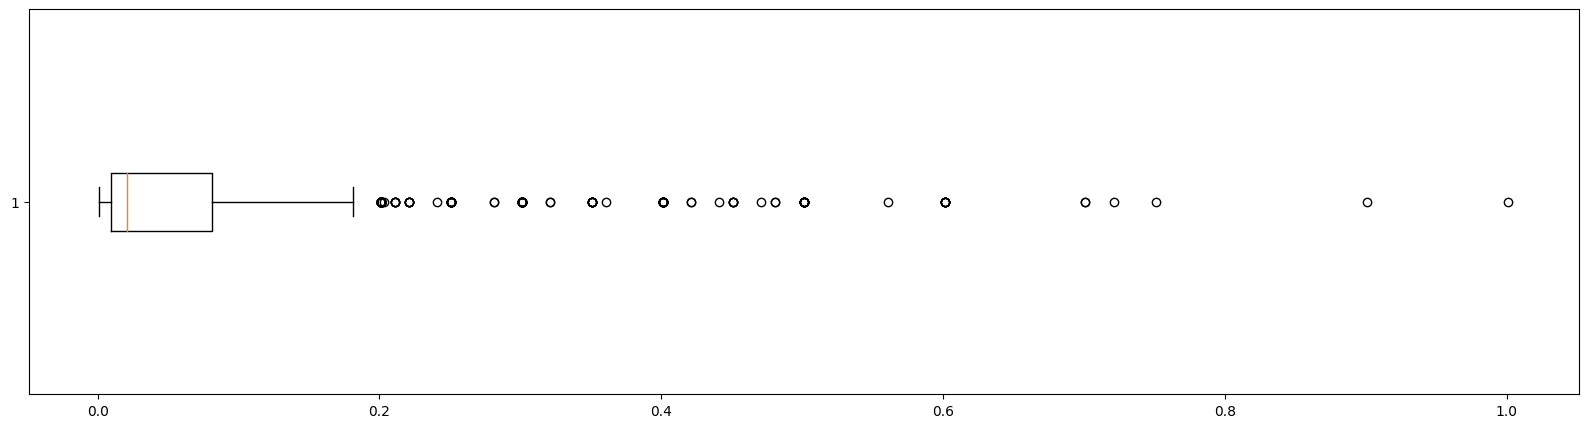

In [14]:
plt.figure(figsize=(20, 5))
plt.boxplot(dat['emailmintotal_center'], vert=False)
plt.show()

Có thể thấy dữ liệu emailmintotal rất phân tán, giá trị trong khoảng [0, 6000]. Dữ liệu tập trung nhiều ở vùng giá trị thấp, hình ảnh right skewed rõ nét.

Ta xem thêm biểu đồ histogram về phân phối của dữ liệu:

(0.0, 100.0)

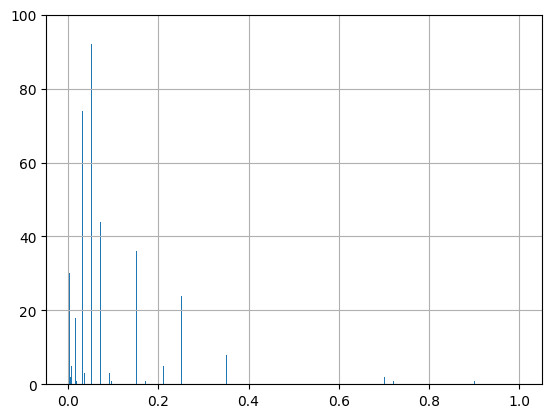

In [15]:
dat['emailmintotal_center'].hist(bins = 1300)
plt.ylim([0,100])

Có thể thấy, emailmintotal là biến liên tục không âm, gợi ý về phân phối Gamma (ta có thể cộng thêm 1 hằng số dương để đảm bảo giá trị luôn dương). Và với biểu đồ histogram phía trên cũng có hình ảnh phân phối Gamma.

Ta sẽ dùng biểu đồ QQplot để kiểm tra thêm việc này.

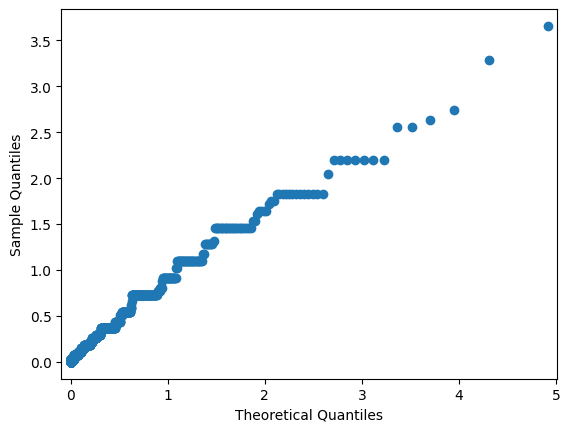

In [16]:
qqplot(dat["emailmintotal_center"],gamma,fit=True)
plt.show()

Như vậy, emailmintotal khá khớp với phân phối **Gamma**

**1.b. Xem xét sự phụ thuộc của biến đầu ra so với các biến giải thích**

Xem xét emailmintotal đối với các cột categorical

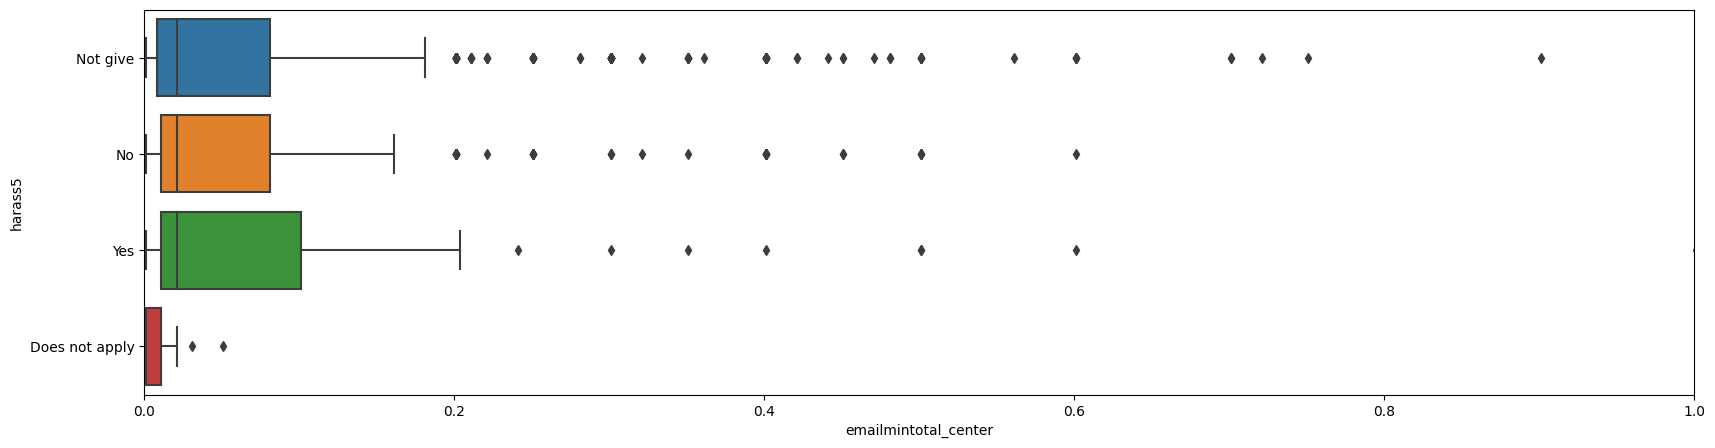

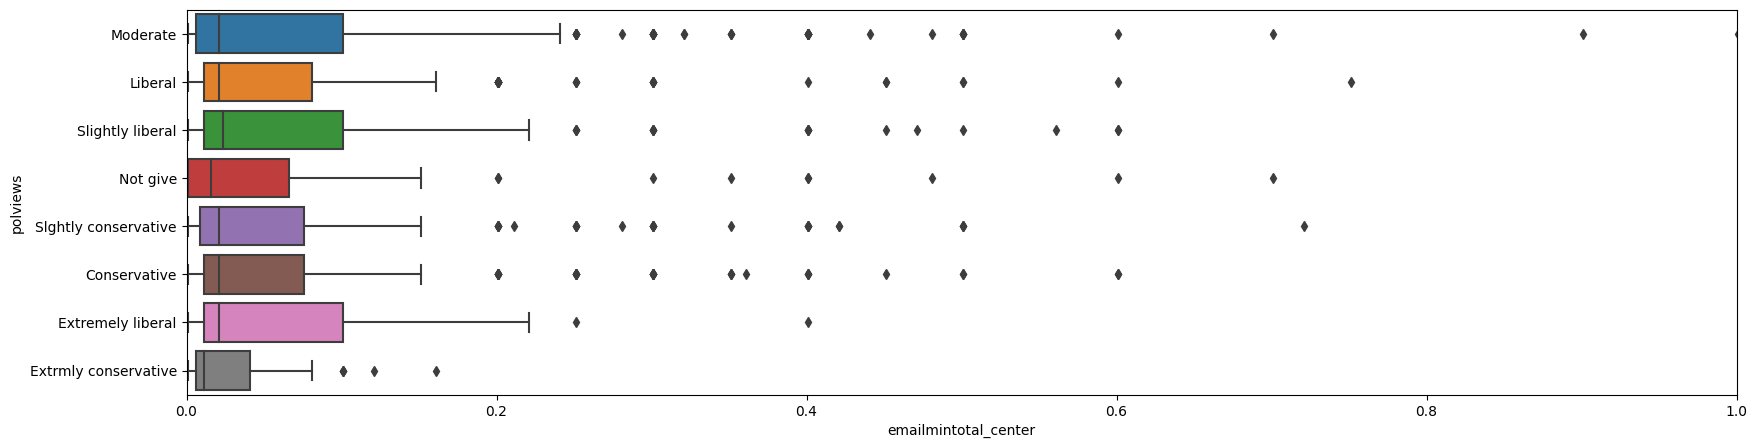

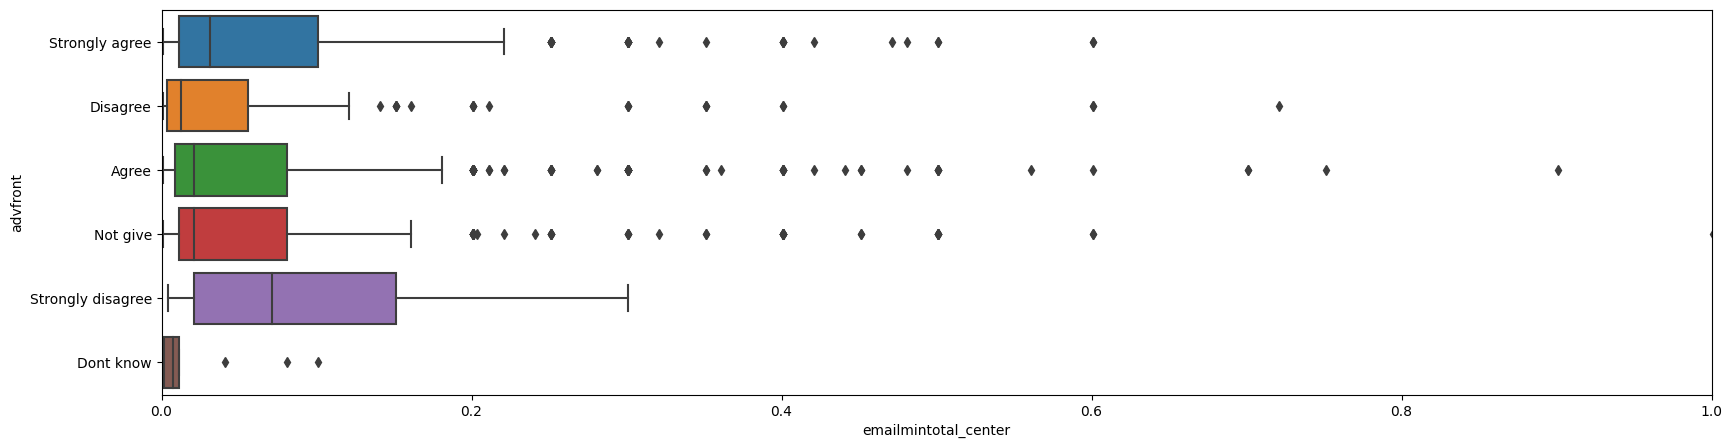

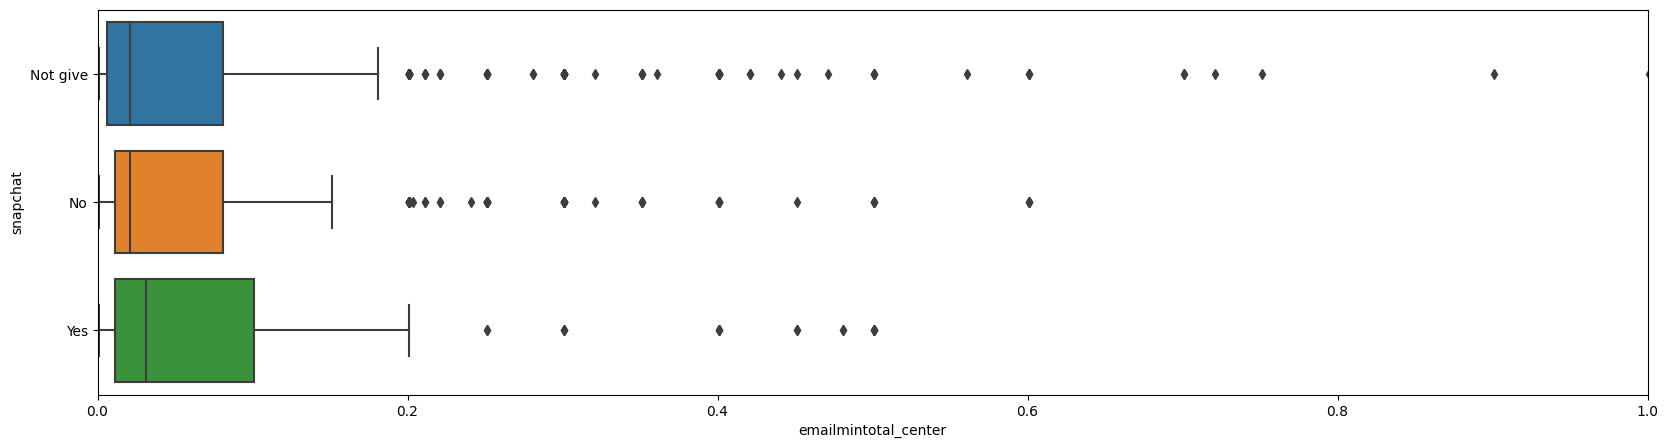

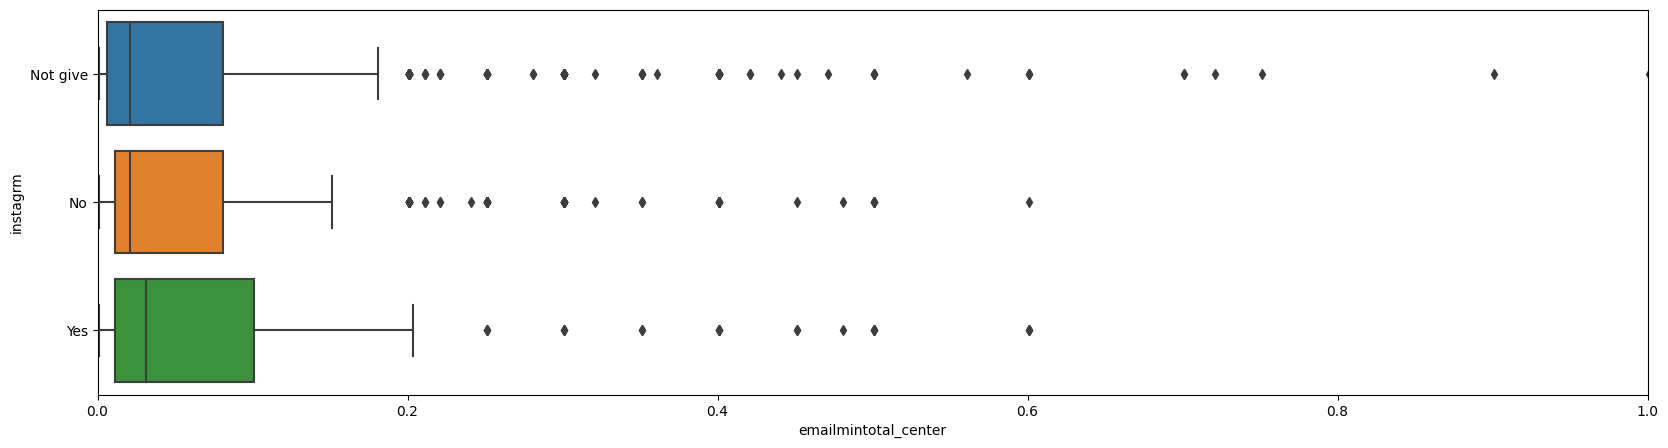

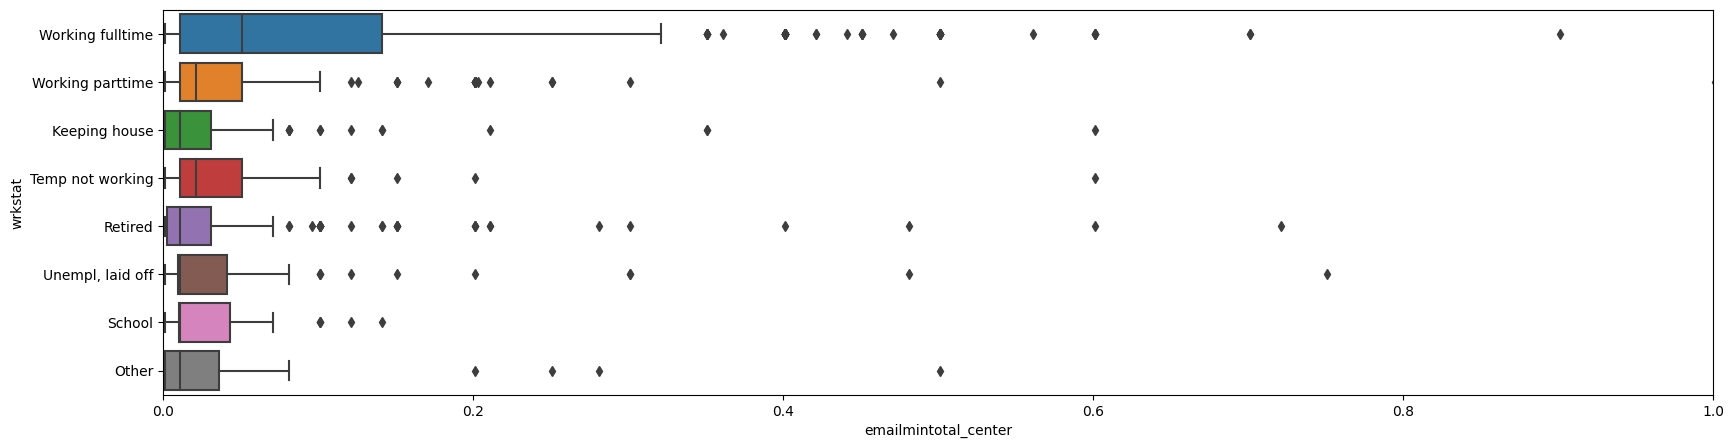

In [17]:
import seaborn as sns

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="harass5")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="polviews")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="advfront")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="snapchat")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="instagrm")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="wrkstat")
plt.xlim([0, 1])
plt.show()

Nhận xét:
- **harass**: nhóm không đi làm ít dùng email hơn 3 nhóm còn lại.
- **polviews**: nhóm Extrmly conservative dùng email ít hơn các nhóm còn lại.
- **advfront**: nhóm Strong disagree dùng nhiều email hơn hẳn các nhóm còn lại, sau đó tới nhóm Strong agree. Nhóm Dont know là dùng email ít nhất.
- **snapchat, instagrm**:  Nhân tố Snapchat và nhân tố Instagram có phân bố như nhau trên cả 3 giá trị (Dont know, No, Yes). Trong đó nhóm Yes dùng email nhiều hơn 2 nhóm còn lại, nghĩa là người dùng mạng xã hội có xu hướng dùng email nhiều hơn.
- **wrkstat**: nhóm "working fulltime" dùng email nhiều hơn hẳn các nhóm còn lại. Các nhóm không đi làm (Keeping house, Retired, Unempl/laid off, School, Other) có mức dùng email ít nhất. Các nhóm làm bán thời gian (working parttime, temp not working) có mức dùng email ở giữa nhóm đi làm và nhóm không đi làm.

Bản thân trong mỗi nhóm, số lượng outlier vẫn khá nhiều (dữ liệu khá phân tán).

Tiếp theo, xem xét sự phụ thuộc của emailmintotal đối với biến educ (biến dạng số duy nhất ở đây)

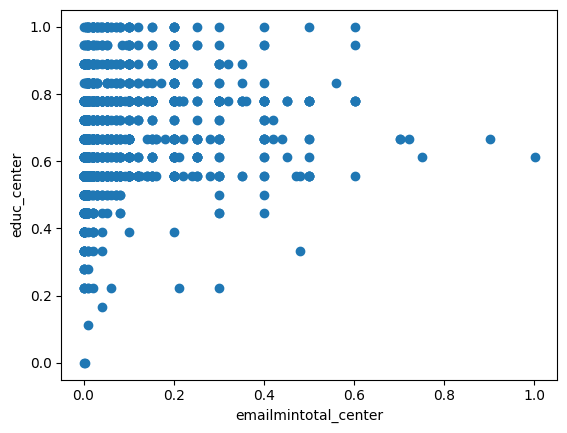

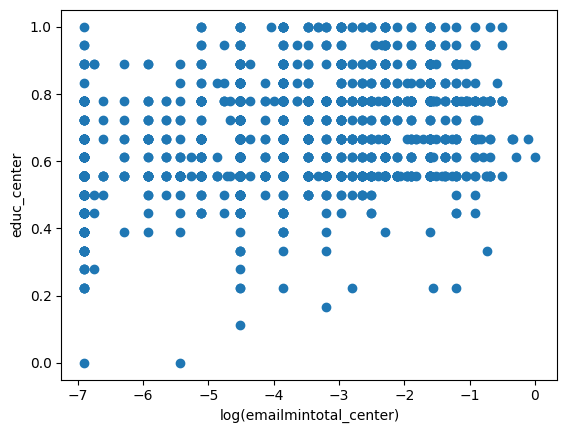

In [18]:
plt.scatter(dat["emailmintotal_center"], dat["educ_center"])
plt.xlabel("emailmintotal_center")
plt.ylabel("educ_center")
plt.show()

plt.scatter(np.log(dat["emailmintotal_center"]), dat["educ_center"])
plt.xlabel("log(emailmintotal_center)")
plt.ylabel("educ_center")
plt.show()


Biểu đồ scatter giữa educ và emailmintotal chưa thấy rõ được quan hệ tuyến tính giữa 2 biến này.

Ta chuyển scale cho emailmintotal bằng hàm log và kiểm tra lại. Ta thấy educ so với log(emailmintotal) có quan hệ có vẻ tuyến tính hơn, mặc dù độ phân tán khá lớn. Điều này gợi ý ta dùng **link function là hàm log**.

Vì sự quan hệ tuyến tính giữa educ và log(emailmintotal) không thể hiện sắc nét nên có thể giữa 2 biến này có quan hệ phi tuyến. Vì vậy, bên cạnh mô hình GLM, chúng em sẽ thử nghiệm thêm mô hình GAM để giải quyết vấn đề này.

Trong phần tiếp theo ta sẽ lựa chọn và xây dựng mô hình để dự đoán cho emailmintotal. **2 mô hình được lựa chọn thử nghiệm là GLM (Generalized Linear Model) và GAM (Generalized Additive Model).**

Trước tiên, ta tạm chia tập train/test theo tỷ lệ 80:20:

In [19]:
# dat_dm = pd.get_dummies(dat, dtype=int)
# dat_dm['emailmintotal_center'] += 1e-2

# y = dat_dm['emailmintotal_center']
# X = dat_dm.drop(columns=['emailmintotal_center'],axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



dat_train = dat.sample(frac = 0.8, random_state = 42)
dat_test = dat.drop(dat_train.index)

In [36]:
print(dat_train.shape)

(1308, 12)


# 2. Mô hình GLM

**2.a. Lựa chọn thuộc tính**

Sau đó ta thử cho tất cả các cột vào fit mô hình GLM xem kết quả như thế nào:

In [20]:
formula_str = 'emailmintotal_center ~ harass5 + educ_center + polviews + advfront + snapchat + instagrm + wrkstat'

fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
fitted_glm.summary()


# fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.InverseGaussian(link=sm.families.links.Log())).fit()

### dummies
## fitted_glm = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# print('AIC: ', fitted_glm.aic)

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1291
Model Family:                     Gamma   Df Model:                           26
Link Function:                      Log   Scale:                          2.5356
Method:                            IRLS   Log-Likelihood:                 2437.3
Date:                  Mon, 14 Aug 2023   Deviance:                       2690.8
Time:                          17:36:43   Pearson chi2:                 3.27e+03
No. Iterations:                     100   Pseudo R-squ. (CS):             0.1319
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.2501      1.258     -2.583      0.010      -5.716      -0.784
harass5[T.No]                        0.7485      0.432      1.734      0.083      -0.098       1.595
harass5[T.Not give]                 -1.7322      1.210     -1.431      0.152      -4.104       0.640
harass5[T.Yes]                       1.1476      0.484      2.372      0.018       0.199       2.096
polviews[T.Extremely liberal]       -0.4037      0.240     -1.684      0.092      -0.874       0.066
polviews[T.Extrmly conservative]    -0.6371      0.264     -2.412      0.016      -1.155      -0.119
polviews[T.Liberal]                 -0.1692      0.172     -0.986      0.324      -0.506       0.167
polviews[T.Moderate]                 0.0160      0.138      0.116      0.907      -0.254       0.286
polviews[T.Not give]                 0.5576      0.267      2.091      0.036       0.035       1.080
polviews[T.Slghtly conservative]    -0.2678      0.164     -1.632      0.103      -0.589       0.054
polviews[T.Slightly liberal]        -0.0501      0.178     -0.281      0.779      -0.399       0.299
advfront[T.Disagree]                 0.4446      0.166      2.685      0.007       0.120       0.769
advfront[T.Dont know]               -0.3914      0.517     -0.756      0.449      -1.406       0.623
advfront[T.Not give]                -2.5902      1.140     -2.273      0.023      -4.824      -0.356
advfront[T.Strongly agree]           0.0846      0.116      0.729      0.466      -0.143       0.312
advfront[T.Strongly disagree]        0.4545      0.568      0.800      0.424      -0.659       1.568
snapchat[T.Not give]                -0.0250      0.057     -0.438      0.661      -0.137       0.087
snapchat[T.Yes]                      0.2127      0.188      1.130      0.259      -0.156       0.582
instagrm[T.Not give]                -0.0250      0.057     -0.438      0.661      -0.137       0.087
instagrm[T.Yes]                      0.0450      0.169      0.266      0.790      -0.286       0.376
wrkstat[T.Other]                     1.2707      0.398      3.189      0.001       0.490       2.052
wrkstat[T.Retired]                   0.2640      0.185      1.425      0.154      -0.099       0.627
wrkstat[T.School]                    0.2135      0.309      0.690      0.490      -0.393       0.820
wrkstat[T.Temp not working]          0.7148      0.333      2.149      0.032       0.063       1.367
wrkstat[T.Unempl, laid off]          0.8953      0.264      3.392      0.001       0.378       1.413
wrkstat[T.Working fulltime]          1.2619      0.165      7.631      0.000       0.938       1.586
wrkstat[T.Working parttime]          0.7524      0.199      3.774      0.000       0.362       1.143
educ_center                    

Nhìn vào kết quả của mô hình sau khi fit, với mức ý nghĩa 5% thì thuộc tính snapchat và instagrm không ảnh hưởng đến mô hình.

Ta loại 2 thuộc tính này và fit lại mô hình thử xem

In [21]:
formula_str = 'emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5'

fitted_glm = NULL
fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1294
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.4903
Method:                            IRLS   Log-Likelihood:                 2441.4
Date:                  Mon, 14 Aug 2023   Deviance:                       2699.9
Time:                          17:36:43   Pearson chi2:                 3.22e+03
No. Iterations:                      22   Pseudo R-squ. (CS):             0.1317
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.2474      1.236     -2.628      0.009      -5.670      -0.825
wrkstat[T.Other]                     1.2419      0.394      3.148      0.002       0.469       2.015
wrkstat[T.Retired]                   0.2334      0.182      1.281      0.200      -0.124       0.590
wrkstat[T.School]                    0.2277      0.304      0.749      0.454      -0.368       0.823
wrkstat[T.Temp not working]          0.7516      0.328      2.292      0.022       0.109       1.394
wrkstat[T.Unempl, laid off]          0.9265      0.261      3.554      0.000       0.416       1.437
wrkstat[T.Working fulltime]          1.2661      0.163      7.748      0.000       0.946       1.586
wrkstat[T.Working parttime]          0.7756      0.197      3.934      0.000       0.389       1.162
polviews[T.Extremely liberal]       -0.4381      0.237     -1.849      0.064      -0.903       0.026
polviews[T.Extrmly conservative]    -0.6573      0.262     -2.512      0.012      -1.170      -0.145
polviews[T.Liberal]                 -0.1687      0.170     -0.994      0.320      -0.501       0.164
polviews[T.Moderate]                 0.0240      0.136      0.176      0.860      -0.243       0.291
polviews[T.Not give]                 0.5562      0.264      2.107      0.035       0.039       1.074
polviews[T.Slghtly conservative]    -0.2743      0.163     -1.688      0.091      -0.593       0.044
polviews[T.Slightly liberal]        -0.0690      0.176     -0.391      0.696      -0.415       0.277
advfront[T.Disagree]                 0.4452      0.164      2.715      0.007       0.124       0.767
advfront[T.Dont know]               -0.4267      0.512     -0.833      0.405      -1.431       0.578
advfront[T.Not give]                -2.5886      1.125     -2.300      0.021      -4.794      -0.383
advfront[T.Strongly agree]           0.0843      0.115      0.734      0.463      -0.141       0.310
advfront[T.Strongly disagree]        0.4236      0.563      0.752      0.452      -0.680       1.527
harass5[T.No]                        0.7940      0.427      1.861      0.063      -0.042       1.630
harass5[T.Not give]                 -1.7383      1.197     -1.452      0.147      -4.085       0.609
harass5[T.Yes]                       1.1636      0.478      2.434      0.015       0.227       2.100
educ_center                          2.0454      0.308      6.633      0.000       1.441       2.650
====================================================================================================
"""

Nhận xét:

So với mô hình đầy đủ tất cả các feature ban đầu, mô hình phía trên có $R^2$ giảm không đáng kể nhưng mô hình đã đơn giản được 2 biến. Như vậy việc bỏ bớt feature không quan trọng của ta là đúng đắn.

Với mức ý nghĩa 5%, tất cả các feature giữ lại trong mô hình (wrkstat, educ, polviews, advfront, harass5) đều có ý nghĩa thống kê

**2.b. Diagnostic**

**Phần dư**

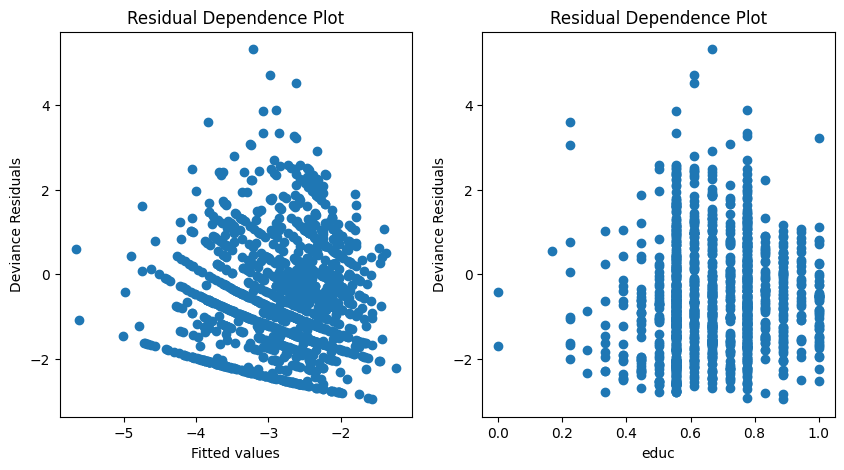

In [22]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

Nhận thấy, giá trị phần dư chuẩn hóa theo biến educ và fitted values có phân phối tương đối cân bằng xung quanh trục y=0.

Ta tiếp tục kiểm tra phân phối chuẩn của phần dư bằng biểu đồ QQplot

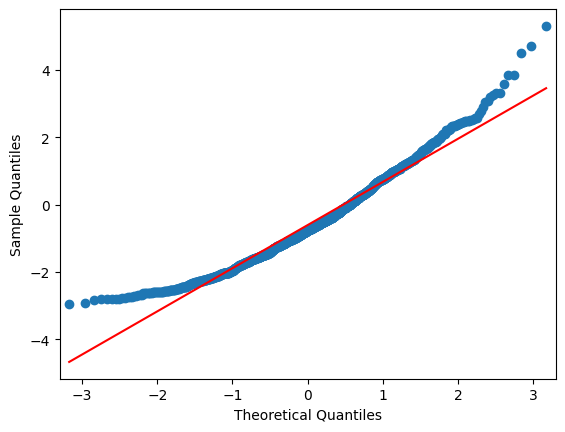

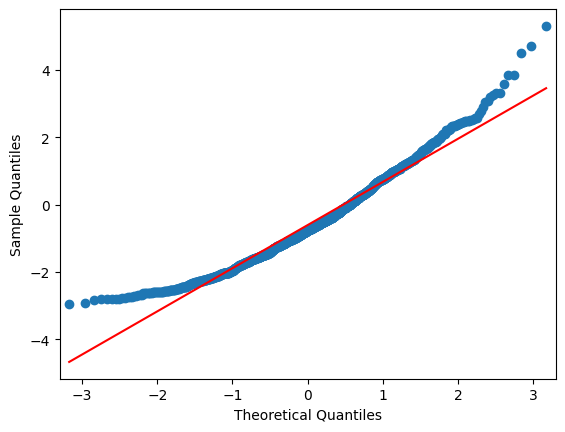

In [23]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Biểu đồ qqplot cho thấy phần dư chuẩn hóa khá khớp với phân phối chuẩn.

Như vậy, mô hình là hợp lý với dữ liệu.


**Các điểm Infuence**

Các điểm influence là các điểm không tuân theo xu hướng chung của các điểm khác trong tập dữ liệu (outlier) và ảnh hưởng nghiêm trọng đến mô hình. Nó là các điểm có phần dư lớn và giá trị đòn bẩy (leverage) lớn.

Vì các điểm này không thể hiện xu hướng chung của dữ liệu, nó gây nhiễu cho mô hình. Mục tiêu của ta làm tìm các điểm này và loại nó khỏi dữ liệu train, sau đó fit lại để có mô hình tốt hơn.

Các điểm Influence được đánh giá qua giá trị Cook's distance. Ta lấy thử ra 10 điểm có Cook's distance lớn nhất.

In [24]:
infl = fitted_glm.get_influence()

summ_df = infl.summary_frame()

outlier_df = summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)[:10]
outlier_df

# cook_df = summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)
# cut_off = 4/len(dat_train)
# outlier = cook_df[cook_df["cooks_d"]>cut_off].index.values.tolist()
# len(outlier) # 109

,cooks_d,standard_resid,hat_diag,dffits_internal
2146,2.596624,12.690348,0.279002,7.551139
263,2.184631,10.566279,0.319551,6.826442
2362,2.174943,9.998486,0.343032,6.724674
1583,1.017832,7.490995,0.303291,4.580353
2354,0.620537,5.700288,0.314288,3.734017
620,0.416985,1.251835,0.864611,3.139379
377,0.341800,2.758610,0.518759,2.794730
2288,0.338738,6.090667,0.179758,2.784835
431,0.330675,6.751776,0.148277,2.906112
1491,0.202084,3.348083,0.302000,2.141122


Quan sát chi tiết 10 điểm có giá trị Cooks_d lớn nhất:

In [25]:
outlier = outlier_df.index.values.tolist()
dat_train.loc[outlier]

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailmintotal,emailmintotal_center,educ_center
2146,Not give,0.0,72.0,14.0,Slghtly conservative,Disagree,Not give,Not give,Retired,4320.0,0.721,0.666667
263,Not give,0.0,75.0,13.0,Liberal,Agree,Not give,Not give,"Unempl, laid off",4500.0,0.751,0.611111
2362,Yes,0.0,100.0,13.0,Moderate,Not give,Not give,Not give,Working parttime,6000.0,1.001,0.611111
1583,No,0.0,60.0,16.0,Not give,Not give,No,No,Keeping house,3600.0,0.601,0.777778
2354,Not give,0.0,60.0,16.0,Conservative,Agree,Not give,Not give,Temp not working,3600.0,0.601,0.777778
620,Not give,30.0,0.0,12.0,Conservative,Not give,No,No,Working parttime,30.0,0.006,0.555556
377,Not give,0.0,21.0,16.0,Moderate,Strongly disagree,Not give,Not give,Keeping house,1260.0,0.211,0.777778
2288,Not give,0.0,21.0,6.0,Moderate,Disagree,Not give,Not give,Retired,1260.0,0.211,0.222222
431,Not give,0.0,50.0,12.0,Conservative,Agree,Yes,Yes,Working parttime,3000.0,0.501,0.555556
1491,Not give,0.0,50.0,14.0,Conservative,Agree,Not give,Not give,Other,3000.0,0.501,0.666667


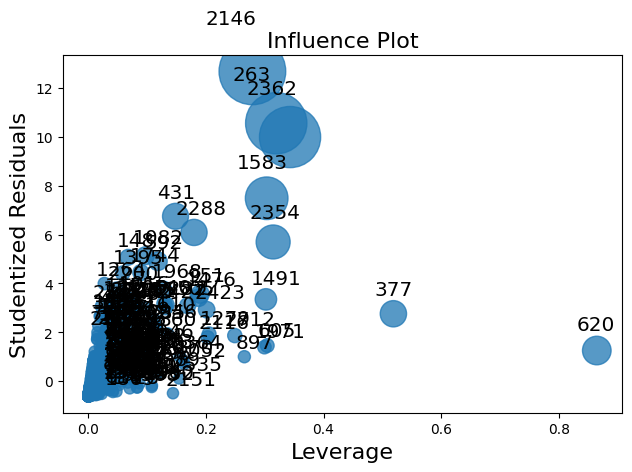

In [26]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

Ta loại bỏ các quan sát có Cook's lớn nhất này và fit lại mô hình, quan sát lại các thông tin đánh giá về residual và phân phối của nó

In [27]:
# dat_train.drop([1583, 2146, 263, 2362], inplace=True)

dat_train.drop(outlier, inplace=True)

In [28]:
fitted_glm = NULL
fitted_glm = smf.glm(formula='emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5', \
                     data=dat_train, \
                     family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1308
Model:                              GLM   Df Residuals:                     1284
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.0151
Method:                            IRLS   Log-Likelihood:                 2538.2
Date:                  Mon, 14 Aug 2023   Deviance:                       2534.0
Time:                          17:36:44   Pearson chi2:                 2.59e+03
No. Iterations:                      21   Pseudo R-squ. (CS):             0.1840
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.9200      1.503     -1.277      0.202      -4.866       1.026
wrkstat[T.Other]                     1.1130      0.364      3.060      0.002       0.400       1.826
wrkstat[T.Retired]                   0.1982      0.165      1.200      0.230      -0.126       0.522
wrkstat[T.School]                    0.3128      0.274      1.142      0.253      -0.224       0.850
wrkstat[T.Temp not working]          0.4874      0.299      1.627      0.104      -0.100       1.074
wrkstat[T.Unempl, laid off]          0.7449      0.236      3.150      0.002       0.281       1.208
wrkstat[T.Working fulltime]          1.3667      0.148      9.227      0.000       1.076       1.657
wrkstat[T.Working parttime]          0.6630      0.179      3.705      0.000       0.312       1.014
polviews[T.Extremely liberal]       -0.2876      0.215     -1.338      0.181      -0.709       0.134
polviews[T.Extrmly conservative]    -0.4481      0.236     -1.900      0.057      -0.910       0.014
polviews[T.Liberal]                 -0.1469      0.154     -0.956      0.339      -0.448       0.154
polviews[T.Moderate]                 0.0949      0.124      0.768      0.442      -0.147       0.337
polviews[T.Not give]                 0.4905      0.240      2.045      0.041       0.021       0.961
polviews[T.Slghtly conservative]    -0.2878      0.147     -1.957      0.050      -0.576       0.000
polviews[T.Slightly liberal]         0.0390      0.159      0.245      0.807      -0.273       0.351
advfront[T.Disagree]                 0.2516      0.149      1.691      0.091      -0.040       0.543
advfront[T.Dont know]               -0.2308      0.461     -0.501      0.617      -1.135       0.673
advfront[T.Not give]                -3.9907      1.435     -2.782      0.005      -6.803      -1.179
advfront[T.Strongly agree]           0.1397      0.104      1.349      0.177      -0.063       0.343
advfront[T.Strongly disagree]       -0.0912      0.541     -0.168      0.866      -1.152       0.970
harass5[T.No]                        0.6852      0.384      1.785      0.074      -0.067       1.438
harass5[T.Not give]                 -3.2634      1.479     -2.206      0.027      -6.163      -0.364
harass5[T.Yes]                       0.7280      0.431      1.689      0.091      -0.117       1.573
educ_center                          2.1372      0.279      7.665      0.000       1.591       2.684
====================================================================================================
"""

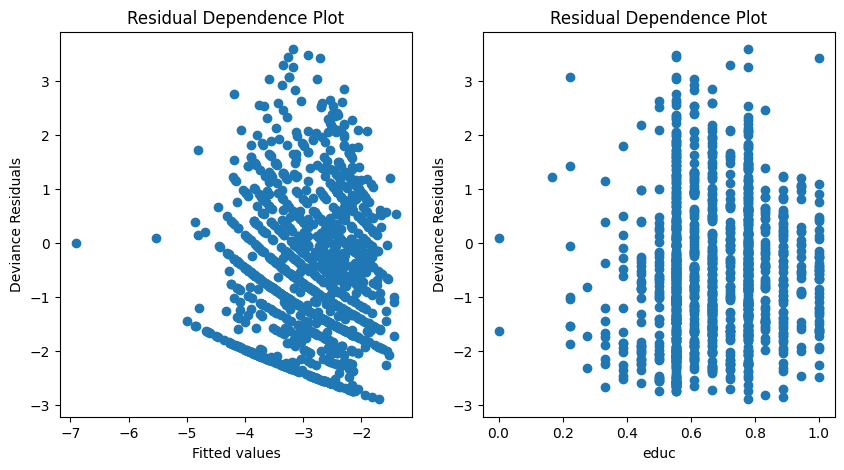

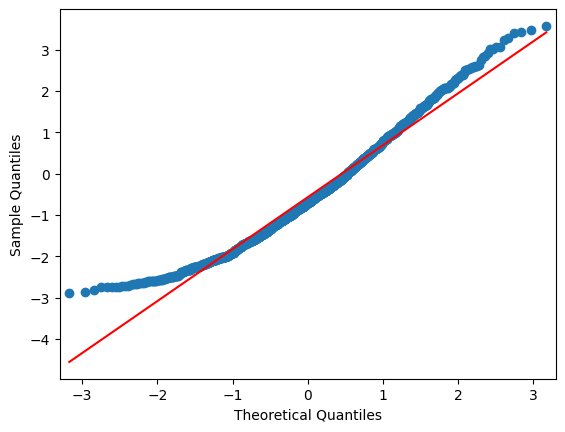

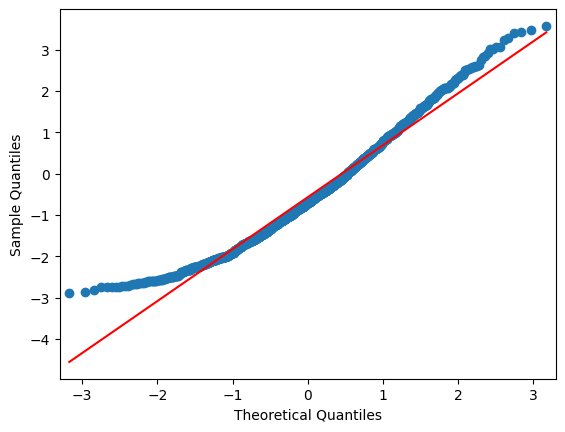

In [29]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Như vậy, sau khi loại bỏ các điểm Influence, mô hình có $R^2$ tăng gần 40%, từ 0.1317 lên 0.1840. Các biểu đồ phần dư cũng cho thấy kết quả đẹp hơn so với mô hình trên tập dữ liệu ban đầu.

# 3. Mô hình GAM

Mô hình hồi quy cộng tính tổng quát (GAM - Generalized Additive Models) là trường hợp tổng quát hơn của GLM. GAM cố gắng mô hình hóa cả tác động của các biến độc lập mà có quan hệ phi tuyến với biến phụ thuộc.

Công thức tổng quát của GAM:

$g(\mu) =  \sum_{k} \alpha_k X_k + \sum_{j} s_j(Z_j)$

Trong đó:

- $\mu=E(Y)$ với $Y$ là biến phụ thuộc có phân phối họ mũ
- $X_k$ là các biến độc lập có tác động tuyến tính đến biến phụ thuộc, các hệ số $\alpha_k$ chưa biết.
- $Z_j$ là các biến độc lập có tác động phi tuyến đến biến phụ thuộc, $s_j(.)$ là hàm trơn (spline)
- $g(.)$ là link function

GAM được ước lượng bằng phương pháp hợp lý cực đại có phạt, trong đó các hàm trơn được ước lượng qua các spline và nút.

Đầu tiên ta thử fit mô hình với tất cả các biến mà GLM đã chọn ở trên. Các tham số của GAM cần chọn:
- degree: bậc của hàm trong 1 đoạn spline
- df (degree of freedom): số bậc tự do của spline
- alpha: hệ số phạt


In [30]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=10, degree=5)
alpha = 10

gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                             data=dat_train, smoother=bs, alpha=alpha, \
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
fitted_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1308
Model:                           GLMGam   Df Residuals:                  1284.19
Model Family:                     Gamma   Df Model:                        22.81
Link Function:                      Log   Scale:                          2.0143
Method:                           PIRLS   Log-Likelihood:                 2538.5
Date:                  Mon, 14 Aug 2023   Deviance:                       2533.3
Time:                          17:36:45   Pearson chi2:                 2.59e+03
No. Iterations:                      15   Pseudo R-squ. (CS):             0.1842
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.9400      1.505     -1.289      0.197      -4.889       1.009
wrkstat[T.Other]                     1.1140      0.364      3.063      0.002       0.401       1.827
wrkstat[T.Retired]                   0.1983      0.165      1.201      0.230      -0.125       0.522
wrkstat[T.School]                    0.3126      0.274      1.141      0.254      -0.224       0.849
wrkstat[T.Temp not working]          0.4880      0.299      1.630      0.103      -0.099       1.075
wrkstat[T.Unempl, laid off]          0.7448      0.236      3.150      0.002       0.281       1.208
wrkstat[T.Working fulltime]          1.3667      0.148      9.228      0.000       1.076       1.657
wrkstat[T.Working parttime]          0.6633      0.179      3.707      0.000       0.313       1.014
polviews[T.Extremely liberal]       -0.2874      0.215     -1.337      0.181      -0.709       0.134
polviews[T.Extrmly conservative]    -0.4482      0.236     -1.901      0.057      -0.910       0.014
polviews[T.Liberal]                 -0.1468      0.154     -0.955      0.339      -0.448       0.154
polviews[T.Moderate]                 0.0944      0.124      0.763      0.445      -0.148       0.337
polviews[T.Not give]                 0.4898      0.240      2.043      0.041       0.020       0.960
polviews[T.Slghtly conservative]    -0.2879      0.147     -1.957      0.050      -0.576       0.000
polviews[T.Slightly liberal]         0.0383      0.159      0.241      0.810      -0.274       0.351
advfront[T.Disagree]                 0.2527      0.149      1.699      0.089      -0.039       0.544
advfront[T.Dont know]               -0.2322      0.461     -0.504      0.615      -1.136       0.671
advfront[T.Not give]                -3.9912      1.434     -2.782      0.005      -6.803      -1.180
advfront[T.Strongly agree]           0.1399      0.104      1.351      0.177      -0.063       0.343
advfront[T.Strongly disagree]       -0.0869      0.541     -0.161      0.872      -1.148       0.974
harass5[T.No]                        0.6850      0.384      1.784      0.074      -0.067       1.437
harass5[T.Not give]                 -3.2641      1.479     -2.207      0.027      -6.163      -0.365
harass5[T.Yes]                       0.7288      0.431      1.691      0.091      -0.116       1.574
educ_center_s0                       0.2417      0.041      5.914      0.000       0.162       0.322
educ_center_s1                       0.5075      0.085      5.993      0.000       0.342       0.673
educ_center_s2                       0.8207      0.131      6.273      0.000       0.564       1.077
educ_center_s3                       1.1626      0.172      6.770      0.000       0.826       1.499
educ_center_s4                 

Cố định các tham số degree, df, dùng grid search để chọn alpha tối ưu thông qua tính toán AIC, BIC.

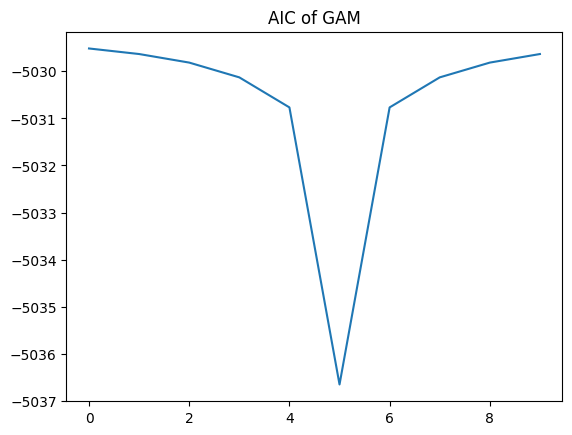

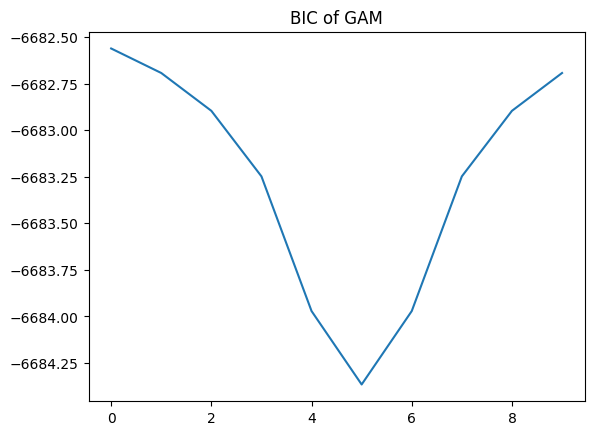

In [31]:
aic_gam = []
bic_gam = []

al = [0.001, 0.01, 0.1, 1]
al = range(-5, 5, 1)
# al = range(20)

for i in range(len(al)):
    x_spline = dat_train["educ_center"]
    bs = BSplines(x_spline, df=5, degree=3)

    gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                                 data=dat_train, smoother=bs, alpha=al[i], \
                                 family=sm.families.Gamma(link=sm.families.links.Log()))

    fitted_gam = gam_bs.fit()

    aic_gam.append(fitted_gam.aic)
    bic_gam.append(fitted_gam.bic)

plt.plot(range(len(aic_gam)), aic_gam)
plt.title("AIC of GAM")
plt.show()

plt.plot(range(len(bic_gam)), bic_gam)
plt.title("BIC of GAM")
plt.show()

Như vậy, trường hợp này, alpha tối ưu bằng 1. Ta fit lại mô hình GAM để xem kết quả

In [32]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=10, degree=3)

# gam_bs = GLMGam.from_formula(formula = 'emailmintotal ~ wrkstat + polviews + advfront + harass5', \
gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                                data=dat_train, smoother=bs, alpha=1, \
                                family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
fitted_gam.summary()

# #"wrkstat", "educ", "polviews", "advfront", "harass5", "wrkstat:educ", "polviews:advfront", "wrkstat:harass5", "snapchat:instagrm", "instagrm", "snapchat"

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1308
Model:                           GLMGam   Df Residuals:                  1283.84
Model Family:                     Gamma   Df Model:                        23.16
Link Function:                      Log   Scale:                          2.0123
Method:                           PIRLS   Log-Likelihood:                 2539.8
Date:                  Mon, 14 Aug 2023   Deviance:                       2528.9
Time:                          17:36:46   Pearson chi2:                 2.58e+03
No. Iterations:                      17   Pseudo R-squ. (CS):             0.1858
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -2.0735      1.520     -1.364      0.172      -5.052       0.905
wrkstat[T.Other]                     1.1213      0.364      3.084      0.002       0.409       1.834
wrkstat[T.Retired]                   0.1993      0.165      1.207      0.227      -0.124       0.523
wrkstat[T.School]                    0.3109      0.274      1.135      0.256      -0.226       0.848
wrkstat[T.Temp not working]          0.4922      0.299      1.645      0.100      -0.094       1.079
wrkstat[T.Unempl, laid off]          0.7443      0.236      3.149      0.002       0.281       1.208
wrkstat[T.Working fulltime]          1.3663      0.148      9.224      0.000       1.076       1.657
wrkstat[T.Working parttime]          0.6656      0.179      3.720      0.000       0.315       1.016
polviews[T.Extremely liberal]       -0.2855      0.215     -1.327      0.185      -0.707       0.136
polviews[T.Extrmly conservative]    -0.4480      0.236     -1.900      0.057      -0.910       0.014
polviews[T.Liberal]                 -0.1458      0.154     -0.949      0.343      -0.447       0.155
polviews[T.Moderate]                 0.0904      0.124      0.732      0.464      -0.152       0.333
polviews[T.Not give]                 0.4853      0.240      2.025      0.043       0.016       0.955
polviews[T.Slghtly conservative]    -0.2882      0.147     -1.960      0.050      -0.576    5.57e-05
polviews[T.Slightly liberal]         0.0336      0.159      0.211      0.833      -0.279       0.346
advfront[T.Disagree]                 0.2604      0.149      1.751      0.080      -0.031       0.552
advfront[T.Dont know]               -0.2419      0.461     -0.525      0.600      -1.145       0.661
advfront[T.Not give]                -3.9939      1.434     -2.785      0.005      -6.804      -1.184
advfront[T.Strongly agree]           0.1419      0.104      1.371      0.171      -0.061       0.345
advfront[T.Strongly disagree]       -0.0568      0.542     -0.105      0.917      -1.120       1.006
harass5[T.No]                        0.6837      0.384      1.782      0.075      -0.068       1.436
harass5[T.Not give]                 -3.2674      1.478     -2.210      0.027      -6.165      -0.370
harass5[T.Yes]                       0.7347      0.431      1.705      0.088      -0.110       1.579
educ_center_s0                       0.4469      0.147      3.040      0.002       0.159       0.735
educ_center_s1                       0.9059      0.271      3.348      0.001       0.376       1.436
educ_center_s2                       1.3903      0.302      4.605      0.000       0.798       1.982
educ_center_s3                       1.4780      0.309      4.784      0.000       0.872       2.084
educ_center_s4                 

Có thể thấy, so với GML thì trong trường hợp này GAM cho kết quả $R^2$ cải thiện 1 chút

# 4. So sánh kết quả 2 mô hình

Để so sánh GLM và GAM không chỉ riêng trong 1 trường hợp cụ thể như trên, phần này ta sẽ dùng **Cross Validation** để cùng chia tập train/test theo các cách khác nhau, ghi lại kết quả và so sánh trung bình các thông số đánh giá của 2 mô hình như RMSE, $R^2$.

In [33]:
X_train_ = dat_train[["emailmintotal","wrkstat", "educ_center", "polviews", "advfront", "harass5"]]
y_train_ = dat_train['emailmintotal']

In [38]:
from sklearn.metrics import r2_score

RMSE of GLM: 0.1022
R2 score: 0.05344880023906573


In [ ]:
# predict GLM


# X_test = dat_test.drop(["emailmintotal_center"], axis=1)
X_test = dat_test[["wrkstat", "educ_center", "polviews", "advfront", "harass5"]]
y_test = dat_test['emailmintotal_center']

yhat = fitted_glm.predict(X_test)
print('RMSE of GLM: {0:.4f}'.format(rmse(yhat, y_test)))
r2 = r2_score(y_test, yhat)
print(f'R2 score: {r2}')

# fitted_glm.fittedvalues

In [39]:
# predict GAM

y_hat_gam = fitted_gam.predict(X_test, exog_smooth=X_test[["educ_center"]])

print('RMSE of GAM: {0:.4f}'.format(rmse(y_hat_gam, y_test)))

r2 = r2_score(y_test, y_hat_gam)
print(f'R2 score: {r2}')

RMSE of GAM: 0.1020
R2 score: 0.05621697731551156


# 5. Kết luận

Mô hình nào tốt hơn, vì sao

Vì sao $R^2$ thấp:
- dữ liệu rất phân tán. Nếu dùng ngưỡng xác định outlier thông thường với Cook's distance là 4/n (n là số dòng của tập dữ liệu train) thì có tới 110/1318 mẫu được xác định là outlier (chiếm 8,4%). Chúng em đã thử loại bỏ toàn bộ 111 mẫu này khỏi tập dữ liệu và train lại mô hình thì $R^2$ đạt cỡ trên 36% (khoảng gấp 3 lần $R^2$ nếu dùng cùng mô hình trên tập dữ liệu chưa loại outlier). Tuy nhiên, để đảm bảo tập dữ liệu gốc, chúng em chỉ loại 10 điểm có Cook's distance lớn nhất thì thấy $R^2$ đã tăng gần 40%.
- tập dữ liệu tuy không nhỏ nhưng rất nhiều dòng chứa giá trị NaN.
- Liên quan tới thời gian dùng email của 1 người thì có thể có những thông tin quan trọng hơn mà tập dữ liệu này không cung cấp. Ví dụ cùng là làm việc fulltime nhưng với từng nghề nghiệp cụ thể, như công nhân so với nhân viên văn phòng sẽ có mức dùng email rất khác nhau...